# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 10, 10, 10, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=10, bias=True)
    (2): Tanh()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Tanh()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): Tanh()
    (7): Linear(in_features=10, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 10, 10, 10, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # Aufruf LR scheduler für reduce on plateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.1651
Epoch 1/200, Iteration 2/25, Loss: 0.1126
Epoch 1/200, Iteration 3/25, Loss: 0.0803
Epoch 1/200, Iteration 4/25, Loss: 0.0677
Epoch 1/200, Iteration 5/25, Loss: 0.0394
Epoch 1/200, Iteration 6/25, Loss: 0.0501
Epoch 1/200, Iteration 7/25, Loss: 0.0308
Epoch 1/200, Iteration 8/25, Loss: 0.0274
Epoch 1/200, Iteration 9/25, Loss: 0.0322
Epoch 1/200, Iteration 10/25, Loss: 0.0475
Epoch 1/200, Iteration 11/25, Loss: 0.0241
Epoch 1/200, Iteration 12/25, Loss: 0.0462
Epoch 1/200, Iteration 13/25, Loss: 0.0380
Epoch 1/200, Iteration 14/25, Loss: 0.0147
Epoch 1/200, Iteration 15/25, Loss: 0.0188
Epoch 1/200, Iteration 16/25, Loss: 0.0407
Epoch 1/200, Iteration 17/25, Loss: 0.0263
Epoch 1/200, Iteration 18/25, Loss: 0.0160
Epoch 1/200, Iteration 19/25, Loss: 0.0295
Epoch 1/200, Iteration 20/25, Loss: 0.0177
Epoch 1/200, Iteration 21/25, Loss: 0.0270
Epoch 1/200, Iteration 22/25, Loss: 0.0222
Epoch 1/200, Iteration 23/25, Loss: 0.0287
Epoch 1/200, Iterati

Train Error: 
 Accuracy: 2.62%, Avg loss: 0.034029, MRE: 2.630731 

Test Error: 
 Accuracy: 6.0%, Avg loss: 0.030963, MRE: 4.206471 

Epoch 8/200, Iteration 1/25, Loss: 0.0451
Epoch 8/200, Iteration 2/25, Loss: 0.0287
Epoch 8/200, Iteration 3/25, Loss: 0.0194
Epoch 8/200, Iteration 4/25, Loss: 0.0180
Epoch 8/200, Iteration 5/25, Loss: 0.0286
Epoch 8/200, Iteration 6/25, Loss: 0.0082
Epoch 8/200, Iteration 7/25, Loss: 0.0248
Epoch 8/200, Iteration 8/25, Loss: 0.0445
Epoch 8/200, Iteration 9/25, Loss: 0.0099
Epoch 8/200, Iteration 10/25, Loss: 0.0133
Epoch 8/200, Iteration 11/25, Loss: 0.0136
Epoch 8/200, Iteration 12/25, Loss: 0.0196
Epoch 8/200, Iteration 13/25, Loss: 0.0379
Epoch 8/200, Iteration 14/25, Loss: 0.0371
Epoch 8/200, Iteration 15/25, Loss: 0.0128
Epoch 8/200, Iteration 16/25, Loss: 0.0142
Epoch 8/200, Iteration 17/25, Loss: 0.0417
Epoch 8/200, Iteration 18/25, Loss: 0.0128
Epoch 8/200, Iteration 19/25, Loss: 0.0403
Epoch 8/200, Iteration 20/25, Loss: 0.0207
Epoch 8/200, It

Train Error: 
 Accuracy: 62.0%, Avg loss: 0.018368, MRE: 0.928686 

Test Error: 
 Accuracy: 60.5%, Avg loss: 0.019332, MRE: 3.300232 

Epoch 15/200, Iteration 1/25, Loss: 0.0240
Epoch 15/200, Iteration 2/25, Loss: 0.0251
Epoch 15/200, Iteration 3/25, Loss: 0.0198
Epoch 15/200, Iteration 4/25, Loss: 0.0358
Epoch 15/200, Iteration 5/25, Loss: 0.0190
Epoch 15/200, Iteration 6/25, Loss: 0.0402
Epoch 15/200, Iteration 7/25, Loss: 0.0136
Epoch 15/200, Iteration 8/25, Loss: 0.0237
Epoch 15/200, Iteration 9/25, Loss: 0.0172
Epoch 15/200, Iteration 10/25, Loss: 0.0692
Epoch 15/200, Iteration 11/25, Loss: 0.0228
Epoch 15/200, Iteration 12/25, Loss: 0.0187
Epoch 15/200, Iteration 13/25, Loss: 0.0116
Epoch 15/200, Iteration 14/25, Loss: 0.0242
Epoch 15/200, Iteration 15/25, Loss: 0.0242
Epoch 15/200, Iteration 16/25, Loss: 0.0103
Epoch 15/200, Iteration 17/25, Loss: 0.0210
Epoch 15/200, Iteration 18/25, Loss: 0.0285
Epoch 15/200, Iteration 19/25, Loss: 0.0273
Epoch 15/200, Iteration 20/25, Loss: 0

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.020755, MRE: 0.955690 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.022474, MRE: 2.264829 

Epoch 22/200, Iteration 1/25, Loss: 0.0228
Epoch 22/200, Iteration 2/25, Loss: 0.0263
Epoch 22/200, Iteration 3/25, Loss: 0.0192
Epoch 22/200, Iteration 4/25, Loss: 0.0237
Epoch 22/200, Iteration 5/25, Loss: 0.0275
Epoch 22/200, Iteration 6/25, Loss: 0.0333
Epoch 22/200, Iteration 7/25, Loss: 0.0325
Epoch 22/200, Iteration 8/25, Loss: 0.0111
Epoch 22/200, Iteration 9/25, Loss: 0.0124
Epoch 22/200, Iteration 10/25, Loss: 0.0135
Epoch 22/200, Iteration 11/25, Loss: 0.0240
Epoch 22/200, Iteration 12/25, Loss: 0.0110
Epoch 22/200, Iteration 13/25, Loss: 0.0169
Epoch 22/200, Iteration 14/25, Loss: 0.0313
Epoch 22/200, Iteration 15/25, Loss: 0.0270
Epoch 22/200, Iteration 16/25, Loss: 0.0343
Epoch 22/200, Iteration 17/25, Loss: 0.0088
Epoch 22/200, Iteration 18/25, Loss: 0.0147
Epoch 22/200, Iteration 19/25, Loss: 0.0285
Epoch 22/200, Iteration 20/25, Loss: 0

Train Error: 
 Accuracy: 71.25%, Avg loss: 0.009001, MRE: 0.650874 

Test Error: 
 Accuracy: 76.0%, Avg loss: 0.008890, MRE: 0.943444 

Epoch 29/200, Iteration 1/25, Loss: 0.0240
Epoch 29/200, Iteration 2/25, Loss: 0.0239
Epoch 29/200, Iteration 3/25, Loss: 0.0213
Epoch 29/200, Iteration 4/25, Loss: 0.0246
Epoch 29/200, Iteration 5/25, Loss: 0.0187
Epoch 29/200, Iteration 6/25, Loss: 0.0082
Epoch 29/200, Iteration 7/25, Loss: 0.0065
Epoch 29/200, Iteration 8/25, Loss: 0.0226
Epoch 29/200, Iteration 9/25, Loss: 0.0213
Epoch 29/200, Iteration 10/25, Loss: 0.0208
Epoch 29/200, Iteration 11/25, Loss: 0.0116
Epoch 29/200, Iteration 12/25, Loss: 0.0121
Epoch 29/200, Iteration 13/25, Loss: 0.0184
Epoch 29/200, Iteration 14/25, Loss: 0.0172
Epoch 29/200, Iteration 15/25, Loss: 0.0123
Epoch 29/200, Iteration 16/25, Loss: 0.0091
Epoch 29/200, Iteration 17/25, Loss: 0.0106
Epoch 29/200, Iteration 18/25, Loss: 0.0127
Epoch 29/200, Iteration 19/25, Loss: 0.0107
Epoch 29/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 85.75%, Avg loss: 0.007227, MRE: 0.519390 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.007682, MRE: 1.063643 

Epoch 36/200, Iteration 1/25, Loss: 0.0147
Epoch 36/200, Iteration 2/25, Loss: 0.0192
Epoch 36/200, Iteration 3/25, Loss: 0.0129
Epoch 36/200, Iteration 4/25, Loss: 0.0131
Epoch 36/200, Iteration 5/25, Loss: 0.0150
Epoch 36/200, Iteration 6/25, Loss: 0.0182
Epoch 36/200, Iteration 7/25, Loss: 0.0214
Epoch 36/200, Iteration 8/25, Loss: 0.0116
Epoch 36/200, Iteration 9/25, Loss: 0.0244
Epoch 36/200, Iteration 10/25, Loss: 0.0322
Epoch 36/200, Iteration 11/25, Loss: 0.0307
Epoch 36/200, Iteration 12/25, Loss: 0.0078
Epoch 36/200, Iteration 13/25, Loss: 0.0267
Epoch 36/200, Iteration 14/25, Loss: 0.0187
Epoch 36/200, Iteration 15/25, Loss: 0.0222
Epoch 36/200, Iteration 16/25, Loss: 0.0121
Epoch 36/200, Iteration 17/25, Loss: 0.0147
Epoch 36/200, Iteration 18/25, Loss: 0.0145
Epoch 36/200, Iteration 19/25, Loss: 0.0229
Epoch 36/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 90.88%, Avg loss: 0.006782, MRE: 0.448639 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.007579, MRE: 1.410802 

Epoch 43/200, Iteration 1/25, Loss: 0.0172
Epoch 43/200, Iteration 2/25, Loss: 0.0235
Epoch 43/200, Iteration 3/25, Loss: 0.0182
Epoch 43/200, Iteration 4/25, Loss: 0.0115
Epoch 43/200, Iteration 5/25, Loss: 0.0366
Epoch 43/200, Iteration 6/25, Loss: 0.0077
Epoch 43/200, Iteration 7/25, Loss: 0.0084
Epoch 43/200, Iteration 8/25, Loss: 0.0083
Epoch 43/200, Iteration 9/25, Loss: 0.0093
Epoch 43/200, Iteration 10/25, Loss: 0.0114
Epoch 43/200, Iteration 11/25, Loss: 0.0149
Epoch 43/200, Iteration 12/25, Loss: 0.0117
Epoch 43/200, Iteration 13/25, Loss: 0.0087
Epoch 43/200, Iteration 14/25, Loss: 0.0101
Epoch 43/200, Iteration 15/25, Loss: 0.0145
Epoch 43/200, Iteration 16/25, Loss: 0.0105
Epoch 43/200, Iteration 17/25, Loss: 0.0152
Epoch 43/200, Iteration 18/25, Loss: 0.0220
Epoch 43/200, Iteration 19/25, Loss: 0.0113
Epoch 43/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 91.62%, Avg loss: 0.006329, MRE: 0.399178 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.006902, MRE: 1.191108 

Epoch 50/200, Iteration 1/25, Loss: 0.0134
Epoch 50/200, Iteration 2/25, Loss: 0.0191
Epoch 50/200, Iteration 3/25, Loss: 0.0385
Epoch 50/200, Iteration 4/25, Loss: 0.0127
Epoch 50/200, Iteration 5/25, Loss: 0.0114
Epoch 50/200, Iteration 6/25, Loss: 0.0092
Epoch 50/200, Iteration 7/25, Loss: 0.0173
Epoch 50/200, Iteration 8/25, Loss: 0.0119
Epoch 50/200, Iteration 9/25, Loss: 0.0123
Epoch 50/200, Iteration 10/25, Loss: 0.0131
Epoch 50/200, Iteration 11/25, Loss: 0.0124
Epoch 50/200, Iteration 12/25, Loss: 0.0129
Epoch 50/200, Iteration 13/25, Loss: 0.0049
Epoch 50/200, Iteration 14/25, Loss: 0.0166
Epoch 50/200, Iteration 15/25, Loss: 0.0134
Epoch 50/200, Iteration 16/25, Loss: 0.0314
Epoch 50/200, Iteration 17/25, Loss: 0.0207
Epoch 50/200, Iteration 18/25, Loss: 0.0089
Epoch 50/200, Iteration 19/25, Loss: 0.0079
Epoch 50/200, Iteration 20/25, Loss: 

Epoch 56/200, Iteration 23/25, Loss: 0.0193
Epoch 56/200, Iteration 24/25, Loss: 0.0144
Epoch 56/200, Iteration 25/25, Loss: 0.0092
Train Error: 
 Accuracy: 95.12%, Avg loss: 0.006414, MRE: 0.370922 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.007434, MRE: 1.313067 

Epoch 57/200, Iteration 1/25, Loss: 0.0113
Epoch 57/200, Iteration 2/25, Loss: 0.0421
Epoch 57/200, Iteration 3/25, Loss: 0.0104
Epoch 57/200, Iteration 4/25, Loss: 0.0172
Epoch 57/200, Iteration 5/25, Loss: 0.0083
Epoch 57/200, Iteration 6/25, Loss: 0.0109
Epoch 57/200, Iteration 7/25, Loss: 0.0079
Epoch 57/200, Iteration 8/25, Loss: 0.0143
Epoch 57/200, Iteration 9/25, Loss: 0.0139
Epoch 57/200, Iteration 10/25, Loss: 0.0118
Epoch 57/200, Iteration 11/25, Loss: 0.0154
Epoch 57/200, Iteration 12/25, Loss: 0.0131
Epoch 57/200, Iteration 13/25, Loss: 0.0144
Epoch 57/200, Iteration 14/25, Loss: 0.0201
Epoch 57/200, Iteration 15/25, Loss: 0.0249
Epoch 57/200, Iteration 16/25, Loss: 0.0103
Epoch 57/200, Iteration 17/25, Loss: 

Train Error: 
 Accuracy: 93.75%, Avg loss: 0.006072, MRE: 0.378749 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.006831, MRE: 1.427923 

Epoch 64/200, Iteration 1/25, Loss: 0.0079
Epoch 64/200, Iteration 2/25, Loss: 0.0149
Epoch 64/200, Iteration 3/25, Loss: 0.0105
Epoch 64/200, Iteration 4/25, Loss: 0.0272
Epoch 64/200, Iteration 5/25, Loss: 0.0083
Epoch 64/200, Iteration 6/25, Loss: 0.0095
Epoch 64/200, Iteration 7/25, Loss: 0.0219
Epoch 64/200, Iteration 8/25, Loss: 0.0215
Epoch 64/200, Iteration 9/25, Loss: 0.0243
Epoch 64/200, Iteration 10/25, Loss: 0.0093
Epoch 64/200, Iteration 11/25, Loss: 0.0199
Epoch 64/200, Iteration 12/25, Loss: 0.0167
Epoch 64/200, Iteration 13/25, Loss: 0.0092
Epoch 64/200, Iteration 14/25, Loss: 0.0205
Epoch 64/200, Iteration 15/25, Loss: 0.0085
Epoch 64/200, Iteration 16/25, Loss: 0.0228
Epoch 64/200, Iteration 17/25, Loss: 0.0107
Epoch 64/200, Iteration 18/25, Loss: 0.0323
Epoch 64/200, Iteration 19/25, Loss: 0.0195
Epoch 64/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 82.38%, Avg loss: 0.007256, MRE: 0.520810 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.007435, MRE: 0.946654 

Epoch 71/200, Iteration 1/25, Loss: 0.0171
Epoch 71/200, Iteration 2/25, Loss: 0.0125
Epoch 71/200, Iteration 3/25, Loss: 0.0153
Epoch 71/200, Iteration 4/25, Loss: 0.0083
Epoch 71/200, Iteration 5/25, Loss: 0.0414
Epoch 71/200, Iteration 6/25, Loss: 0.0144
Epoch 71/200, Iteration 7/25, Loss: 0.0336
Epoch 71/200, Iteration 8/25, Loss: 0.0167
Epoch 71/200, Iteration 9/25, Loss: 0.0141
Epoch 71/200, Iteration 10/25, Loss: 0.0091
Epoch 71/200, Iteration 11/25, Loss: 0.0070
Epoch 71/200, Iteration 12/25, Loss: 0.0127
Epoch 71/200, Iteration 13/25, Loss: 0.0074
Epoch 71/200, Iteration 14/25, Loss: 0.0227
Epoch 71/200, Iteration 15/25, Loss: 0.0121
Epoch 71/200, Iteration 16/25, Loss: 0.0120
Epoch 71/200, Iteration 17/25, Loss: 0.0164
Epoch 71/200, Iteration 18/25, Loss: 0.0096
Epoch 71/200, Iteration 19/25, Loss: 0.0118
Epoch 71/200, Iteration 20/25, Loss: 

Epoch 77/200, Iteration 24/25, Loss: 0.0078
Epoch 77/200, Iteration 25/25, Loss: 0.0077
Train Error: 
 Accuracy: 91.25%, Avg loss: 0.006336, MRE: 0.435406 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.006798, MRE: 1.224934 

Epoch 78/200, Iteration 1/25, Loss: 0.0050
Epoch 78/200, Iteration 2/25, Loss: 0.0149
Epoch 78/200, Iteration 3/25, Loss: 0.0171
Epoch 78/200, Iteration 4/25, Loss: 0.0366
Epoch 78/200, Iteration 5/25, Loss: 0.0289
Epoch 78/200, Iteration 6/25, Loss: 0.0232
Epoch 78/200, Iteration 7/25, Loss: 0.0106
Epoch 78/200, Iteration 8/25, Loss: 0.0307
Epoch 78/200, Iteration 9/25, Loss: 0.0377
Epoch 78/200, Iteration 10/25, Loss: 0.0231
Epoch 78/200, Iteration 11/25, Loss: 0.0363
Epoch 78/200, Iteration 12/25, Loss: 0.0123
Epoch 78/200, Iteration 13/25, Loss: 0.0225
Epoch 78/200, Iteration 14/25, Loss: 0.0236
Epoch 78/200, Iteration 15/25, Loss: 0.0095
Epoch 78/200, Iteration 16/25, Loss: 0.0123
Epoch 78/200, Iteration 17/25, Loss: 0.0115
Epoch 78/200, Iteration 18/25, Loss: 

Epoch 84/200, Iteration 19/25, Loss: 0.0319
Epoch 84/200, Iteration 20/25, Loss: 0.0087
Epoch 84/200, Iteration 21/25, Loss: 0.0087
Epoch 84/200, Iteration 22/25, Loss: 0.0076
Epoch 84/200, Iteration 23/25, Loss: 0.0068
Epoch 84/200, Iteration 24/25, Loss: 0.0097
Epoch 84/200, Iteration 25/25, Loss: 0.0179
Train Error: 
 Accuracy: 88.88%, Avg loss: 0.006725, MRE: 0.438970 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.006924, MRE: 1.245229 

Epoch 85/200, Iteration 1/25, Loss: 0.0128
Epoch 85/200, Iteration 2/25, Loss: 0.0112
Epoch 85/200, Iteration 3/25, Loss: 0.0341
Epoch 85/200, Iteration 4/25, Loss: 0.0129
Epoch 85/200, Iteration 5/25, Loss: 0.0264
Epoch 85/200, Iteration 6/25, Loss: 0.0220
Epoch 85/200, Iteration 7/25, Loss: 0.0082
Epoch 85/200, Iteration 8/25, Loss: 0.0069
Epoch 85/200, Iteration 9/25, Loss: 0.0112
Epoch 85/200, Iteration 10/25, Loss: 0.0082
Epoch 85/200, Iteration 11/25, Loss: 0.0096
Epoch 85/200, Iteration 12/25, Loss: 0.0118
Epoch 85/200, Iteration 13/25, Loss: 

Train Error: 
 Accuracy: 95.25%, Avg loss: 0.007085, MRE: 0.362485 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.008050, MRE: 1.539535 

Epoch 92/200, Iteration 1/25, Loss: 0.0113
Epoch 92/200, Iteration 2/25, Loss: 0.0151
Epoch 92/200, Iteration 3/25, Loss: 0.0093
Epoch 92/200, Iteration 4/25, Loss: 0.0204
Epoch 92/200, Iteration 5/25, Loss: 0.0109
Epoch 92/200, Iteration 6/25, Loss: 0.0161
Epoch 92/200, Iteration 7/25, Loss: 0.0145
Epoch 92/200, Iteration 8/25, Loss: 0.0101
Epoch 92/200, Iteration 9/25, Loss: 0.0137
Epoch 92/200, Iteration 10/25, Loss: 0.0089
Epoch 92/200, Iteration 11/25, Loss: 0.0178
Epoch 92/200, Iteration 12/25, Loss: 0.0205
Epoch 92/200, Iteration 13/25, Loss: 0.0069
Epoch 92/200, Iteration 14/25, Loss: 0.0210
Epoch 92/200, Iteration 15/25, Loss: 0.0230
Epoch 92/200, Iteration 16/25, Loss: 0.0516
Epoch 92/200, Iteration 17/25, Loss: 0.0250
Epoch 92/200, Iteration 18/25, Loss: 0.0319
Epoch 92/200, Iteration 19/25, Loss: 0.0134
Epoch 92/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 90.12%, Avg loss: 0.006361, MRE: 0.400714 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.006738, MRE: 1.216992 

Epoch 99/200, Iteration 1/25, Loss: 0.0144
Epoch 99/200, Iteration 2/25, Loss: 0.0120
Epoch 99/200, Iteration 3/25, Loss: 0.0104
Epoch 99/200, Iteration 4/25, Loss: 0.0144
Epoch 99/200, Iteration 5/25, Loss: 0.0097
Epoch 99/200, Iteration 6/25, Loss: 0.0162
Epoch 99/200, Iteration 7/25, Loss: 0.0114
Epoch 99/200, Iteration 8/25, Loss: 0.0193
Epoch 99/200, Iteration 9/25, Loss: 0.0092
Epoch 99/200, Iteration 10/25, Loss: 0.0091
Epoch 99/200, Iteration 11/25, Loss: 0.0091
Epoch 99/200, Iteration 12/25, Loss: 0.0081
Epoch 99/200, Iteration 13/25, Loss: 0.0189
Epoch 99/200, Iteration 14/25, Loss: 0.0227
Epoch 99/200, Iteration 15/25, Loss: 0.0136
Epoch 99/200, Iteration 16/25, Loss: 0.0082
Epoch 99/200, Iteration 17/25, Loss: 0.0272
Epoch 99/200, Iteration 18/25, Loss: 0.0121
Epoch 99/200, Iteration 19/25, Loss: 0.0214
Epoch 99/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 92.88%, Avg loss: 0.006109, MRE: 0.372011 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.006850, MRE: 1.220990 

Epoch 106/200, Iteration 1/25, Loss: 0.0093
Epoch 106/200, Iteration 2/25, Loss: 0.0209
Epoch 106/200, Iteration 3/25, Loss: 0.0174
Epoch 106/200, Iteration 4/25, Loss: 0.0162
Epoch 106/200, Iteration 5/25, Loss: 0.0221
Epoch 106/200, Iteration 6/25, Loss: 0.0213
Epoch 106/200, Iteration 7/25, Loss: 0.0252
Epoch 106/200, Iteration 8/25, Loss: 0.0171
Epoch 106/200, Iteration 9/25, Loss: 0.0118
Epoch 106/200, Iteration 10/25, Loss: 0.0181
Epoch 106/200, Iteration 11/25, Loss: 0.0068
Epoch 106/200, Iteration 12/25, Loss: 0.0112
Epoch 106/200, Iteration 13/25, Loss: 0.0150
Epoch 106/200, Iteration 14/25, Loss: 0.0138
Epoch 106/200, Iteration 15/25, Loss: 0.0146
Epoch 106/200, Iteration 16/25, Loss: 0.0073
Epoch 106/200, Iteration 17/25, Loss: 0.0160
Epoch 106/200, Iteration 18/25, Loss: 0.0276
Epoch 106/200, Iteration 19/25, Loss: 0.0240
Epoch 106/200, Ite

Train Error: 
 Accuracy: 88.62%, Avg loss: 0.006778, MRE: 0.434089 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.006990, MRE: 1.223049 

Epoch 113/200, Iteration 1/25, Loss: 0.0200
Epoch 113/200, Iteration 2/25, Loss: 0.0153
Epoch 113/200, Iteration 3/25, Loss: 0.0130
Epoch 113/200, Iteration 4/25, Loss: 0.0174
Epoch 113/200, Iteration 5/25, Loss: 0.0112
Epoch 113/200, Iteration 6/25, Loss: 0.0082
Epoch 113/200, Iteration 7/25, Loss: 0.0088
Epoch 113/200, Iteration 8/25, Loss: 0.0115
Epoch 113/200, Iteration 9/25, Loss: 0.0140
Epoch 113/200, Iteration 10/25, Loss: 0.0251
Epoch 113/200, Iteration 11/25, Loss: 0.0351
Epoch 113/200, Iteration 12/25, Loss: 0.0098
Epoch 113/200, Iteration 13/25, Loss: 0.0146
Epoch 113/200, Iteration 14/25, Loss: 0.0098
Epoch 113/200, Iteration 15/25, Loss: 0.0147
Epoch 113/200, Iteration 16/25, Loss: 0.0093
Epoch 113/200, Iteration 17/25, Loss: 0.0098
Epoch 113/200, Iteration 18/25, Loss: 0.0143
Epoch 113/200, Iteration 19/25, Loss: 0.0158
Epoch 113/200, Ite

Train Error: 
 Accuracy: 91.88%, Avg loss: 0.006271, MRE: 0.414980 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.006718, MRE: 1.235632 

Epoch 120/200, Iteration 1/25, Loss: 0.0165
Epoch 120/200, Iteration 2/25, Loss: 0.0189
Epoch 120/200, Iteration 3/25, Loss: 0.0247
Epoch 120/200, Iteration 4/25, Loss: 0.0112
Epoch 120/200, Iteration 5/25, Loss: 0.0206
Epoch 120/200, Iteration 6/25, Loss: 0.0089
Epoch 120/200, Iteration 7/25, Loss: 0.0388
Epoch 120/200, Iteration 8/25, Loss: 0.0275
Epoch 120/200, Iteration 9/25, Loss: 0.0306
Epoch 120/200, Iteration 10/25, Loss: 0.0109
Epoch 120/200, Iteration 11/25, Loss: 0.0259
Epoch 120/200, Iteration 12/25, Loss: 0.0142
Epoch 120/200, Iteration 13/25, Loss: 0.0077
Epoch 120/200, Iteration 14/25, Loss: 0.0085
Epoch 120/200, Iteration 15/25, Loss: 0.0131
Epoch 120/200, Iteration 16/25, Loss: 0.0123
Epoch 120/200, Iteration 17/25, Loss: 0.0123
Epoch 120/200, Iteration 18/25, Loss: 0.0169
Epoch 120/200, Iteration 19/25, Loss: 0.0159
Epoch 120/200, Ite

Train Error: 
 Accuracy: 89.75%, Avg loss: 0.006500, MRE: 0.418242 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.006877, MRE: 1.292543 

Epoch 127/200, Iteration 1/25, Loss: 0.0106
Epoch 127/200, Iteration 2/25, Loss: 0.0137
Epoch 127/200, Iteration 3/25, Loss: 0.0115
Epoch 127/200, Iteration 4/25, Loss: 0.0111
Epoch 127/200, Iteration 5/25, Loss: 0.0138
Epoch 127/200, Iteration 6/25, Loss: 0.0087
Epoch 127/200, Iteration 7/25, Loss: 0.0134
Epoch 127/200, Iteration 8/25, Loss: 0.0088
Epoch 127/200, Iteration 9/25, Loss: 0.0109
Epoch 127/200, Iteration 10/25, Loss: 0.0068
Epoch 127/200, Iteration 11/25, Loss: 0.0143
Epoch 127/200, Iteration 12/25, Loss: 0.0089
Epoch 127/200, Iteration 13/25, Loss: 0.0209
Epoch 127/200, Iteration 14/25, Loss: 0.0390
Epoch 127/200, Iteration 15/25, Loss: 0.0445
Epoch 127/200, Iteration 16/25, Loss: 0.0315
Epoch 127/200, Iteration 17/25, Loss: 0.0330
Epoch 127/200, Iteration 18/25, Loss: 0.0078
Epoch 127/200, Iteration 19/25, Loss: 0.0096
Epoch 127/200, Ite

Train Error: 
 Accuracy: 92.75%, Avg loss: 0.006083, MRE: 0.368574 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.006729, MRE: 1.258479 

Epoch 134/200, Iteration 1/25, Loss: 0.0083
Epoch 134/200, Iteration 2/25, Loss: 0.0169
Epoch 134/200, Iteration 3/25, Loss: 0.0186
Epoch 134/200, Iteration 4/25, Loss: 0.0122
Epoch 134/200, Iteration 5/25, Loss: 0.0260
Epoch 134/200, Iteration 6/25, Loss: 0.0083
Epoch 134/200, Iteration 7/25, Loss: 0.0157
Epoch 134/200, Iteration 8/25, Loss: 0.0225
Epoch 134/200, Iteration 9/25, Loss: 0.0370
Epoch 134/200, Iteration 10/25, Loss: 0.0159
Epoch 134/200, Iteration 11/25, Loss: 0.0080
Epoch 134/200, Iteration 12/25, Loss: 0.0228
Epoch 134/200, Iteration 13/25, Loss: 0.0110
Epoch 134/200, Iteration 14/25, Loss: 0.0103
Epoch 134/200, Iteration 15/25, Loss: 0.0152
Epoch 134/200, Iteration 16/25, Loss: 0.0065
Epoch 134/200, Iteration 17/25, Loss: 0.0277
Epoch 134/200, Iteration 18/25, Loss: 0.0111
Epoch 134/200, Iteration 19/25, Loss: 0.0083
Epoch 134/200, Ite

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.005998, MRE: 0.369784 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.006652, MRE: 1.312093 

Epoch 141/200, Iteration 1/25, Loss: 0.0229
Epoch 141/200, Iteration 2/25, Loss: 0.0315
Epoch 141/200, Iteration 3/25, Loss: 0.0193
Epoch 141/200, Iteration 4/25, Loss: 0.0119
Epoch 141/200, Iteration 5/25, Loss: 0.0094
Epoch 141/200, Iteration 6/25, Loss: 0.0102
Epoch 141/200, Iteration 7/25, Loss: 0.0132
Epoch 141/200, Iteration 8/25, Loss: 0.0119
Epoch 141/200, Iteration 9/25, Loss: 0.0102
Epoch 141/200, Iteration 10/25, Loss: 0.0068
Epoch 141/200, Iteration 11/25, Loss: 0.0171
Epoch 141/200, Iteration 12/25, Loss: 0.0329
Epoch 141/200, Iteration 13/25, Loss: 0.0154
Epoch 141/200, Iteration 14/25, Loss: 0.0064
Epoch 141/200, Iteration 15/25, Loss: 0.0108
Epoch 141/200, Iteration 16/25, Loss: 0.0075
Epoch 141/200, Iteration 17/25, Loss: 0.0232
Epoch 141/200, Iteration 18/25, Loss: 0.0202
Epoch 141/200, Iteration 19/25, Loss: 0.0128
Epoch 141/200, Iter

Train Error: 
 Accuracy: 91.5%, Avg loss: 0.006284, MRE: 0.420660 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.006816, MRE: 1.203300 

Epoch 148/200, Iteration 1/25, Loss: 0.0209
Epoch 148/200, Iteration 2/25, Loss: 0.0114
Epoch 148/200, Iteration 3/25, Loss: 0.0221
Epoch 148/200, Iteration 4/25, Loss: 0.0262
Epoch 148/200, Iteration 5/25, Loss: 0.0119
Epoch 148/200, Iteration 6/25, Loss: 0.0176
Epoch 148/200, Iteration 7/25, Loss: 0.0137
Epoch 148/200, Iteration 8/25, Loss: 0.0212
Epoch 148/200, Iteration 9/25, Loss: 0.0217
Epoch 148/200, Iteration 10/25, Loss: 0.0217
Epoch 148/200, Iteration 11/25, Loss: 0.0178
Epoch 148/200, Iteration 12/25, Loss: 0.0190
Epoch 148/200, Iteration 13/25, Loss: 0.0136
Epoch 148/200, Iteration 14/25, Loss: 0.0126
Epoch 148/200, Iteration 15/25, Loss: 0.0291
Epoch 148/200, Iteration 16/25, Loss: 0.0157
Epoch 148/200, Iteration 17/25, Loss: 0.0180
Epoch 148/200, Iteration 18/25, Loss: 0.0090
Epoch 148/200, Iteration 19/25, Loss: 0.0196
Epoch 148/200, Iter

Train Error: 
 Accuracy: 93.38%, Avg loss: 0.006053, MRE: 0.372707 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.006848, MRE: 1.261168 

Epoch 155/200, Iteration 1/25, Loss: 0.0093
Epoch 155/200, Iteration 2/25, Loss: 0.0079
Epoch 155/200, Iteration 3/25, Loss: 0.0205
Epoch 155/200, Iteration 4/25, Loss: 0.0109
Epoch 155/200, Iteration 5/25, Loss: 0.0117
Epoch 155/200, Iteration 6/25, Loss: 0.0088
Epoch 155/200, Iteration 7/25, Loss: 0.0404
Epoch 155/200, Iteration 8/25, Loss: 0.0131
Epoch 155/200, Iteration 9/25, Loss: 0.0062
Epoch 155/200, Iteration 10/25, Loss: 0.0134
Epoch 155/200, Iteration 11/25, Loss: 0.0190
Epoch 155/200, Iteration 12/25, Loss: 0.0077
Epoch 155/200, Iteration 13/25, Loss: 0.0101
Epoch 155/200, Iteration 14/25, Loss: 0.0311
Epoch 155/200, Iteration 15/25, Loss: 0.0073
Epoch 155/200, Iteration 16/25, Loss: 0.0280
Epoch 155/200, Iteration 17/25, Loss: 0.0063
Epoch 155/200, Iteration 18/25, Loss: 0.0436
Epoch 155/200, Iteration 19/25, Loss: 0.0311
Epoch 155/200, Ite

Epoch 161/200, Iteration 20/25, Loss: 0.0059
Epoch 161/200, Iteration 21/25, Loss: 0.0278
Epoch 161/200, Iteration 22/25, Loss: 0.0150
Epoch 161/200, Iteration 23/25, Loss: 0.0237
Epoch 161/200, Iteration 24/25, Loss: 0.0175
Epoch 161/200, Iteration 25/25, Loss: 0.0231
Train Error: 
 Accuracy: 93.88%, Avg loss: 0.006507, MRE: 0.388439 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.007423, MRE: 1.285085 

Epoch 162/200, Iteration 1/25, Loss: 0.0268
Epoch 162/200, Iteration 2/25, Loss: 0.0316
Epoch 162/200, Iteration 3/25, Loss: 0.0158
Epoch 162/200, Iteration 4/25, Loss: 0.0302
Epoch 162/200, Iteration 5/25, Loss: 0.0190
Epoch 162/200, Iteration 6/25, Loss: 0.0177
Epoch 162/200, Iteration 7/25, Loss: 0.0220
Epoch 162/200, Iteration 8/25, Loss: 0.0406
Epoch 162/200, Iteration 9/25, Loss: 0.0299
Epoch 162/200, Iteration 10/25, Loss: 0.0176
Epoch 162/200, Iteration 11/25, Loss: 0.0267
Epoch 162/200, Iteration 12/25, Loss: 0.0097
Epoch 162/200, Iteration 13/25, Loss: 0.0163
Epoch 162/200, Ite

Train Error: 
 Accuracy: 92.88%, Avg loss: 0.006222, MRE: 0.408310 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.007006, MRE: 1.265946 

Epoch 169/200, Iteration 1/25, Loss: 0.0115
Epoch 169/200, Iteration 2/25, Loss: 0.0117
Epoch 169/200, Iteration 3/25, Loss: 0.0162
Epoch 169/200, Iteration 4/25, Loss: 0.0127
Epoch 169/200, Iteration 5/25, Loss: 0.0108
Epoch 169/200, Iteration 6/25, Loss: 0.0162
Epoch 169/200, Iteration 7/25, Loss: 0.0104
Epoch 169/200, Iteration 8/25, Loss: 0.0094
Epoch 169/200, Iteration 9/25, Loss: 0.0099
Epoch 169/200, Iteration 10/25, Loss: 0.0174
Epoch 169/200, Iteration 11/25, Loss: 0.0156
Epoch 169/200, Iteration 12/25, Loss: 0.0202
Epoch 169/200, Iteration 13/25, Loss: 0.0128
Epoch 169/200, Iteration 14/25, Loss: 0.0133
Epoch 169/200, Iteration 15/25, Loss: 0.0076
Epoch 169/200, Iteration 16/25, Loss: 0.0090
Epoch 169/200, Iteration 17/25, Loss: 0.0162
Epoch 169/200, Iteration 18/25, Loss: 0.0115
Epoch 169/200, Iteration 19/25, Loss: 0.0263
Epoch 169/200, Ite

Train Error: 
 Accuracy: 93.25%, Avg loss: 0.006081, MRE: 0.397093 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.006821, MRE: 1.335229 

Epoch 176/200, Iteration 1/25, Loss: 0.0159
Epoch 176/200, Iteration 2/25, Loss: 0.0137
Epoch 176/200, Iteration 3/25, Loss: 0.0139
Epoch 176/200, Iteration 4/25, Loss: 0.0135
Epoch 176/200, Iteration 5/25, Loss: 0.0242
Epoch 176/200, Iteration 6/25, Loss: 0.0140
Epoch 176/200, Iteration 7/25, Loss: 0.0239
Epoch 176/200, Iteration 8/25, Loss: 0.0212
Epoch 176/200, Iteration 9/25, Loss: 0.0090
Epoch 176/200, Iteration 10/25, Loss: 0.0082
Epoch 176/200, Iteration 11/25, Loss: 0.0117
Epoch 176/200, Iteration 12/25, Loss: 0.0089
Epoch 176/200, Iteration 13/25, Loss: 0.0117
Epoch 176/200, Iteration 14/25, Loss: 0.0155
Epoch 176/200, Iteration 15/25, Loss: 0.0225
Epoch 176/200, Iteration 16/25, Loss: 0.0160
Epoch 176/200, Iteration 17/25, Loss: 0.0079
Epoch 176/200, Iteration 18/25, Loss: 0.0099
Epoch 176/200, Iteration 19/25, Loss: 0.0084
Epoch 176/200, Ite

Epoch 183/200, Iteration 2/25, Loss: 0.0124
Epoch 183/200, Iteration 3/25, Loss: 0.0219
Epoch 183/200, Iteration 4/25, Loss: 0.0064
Epoch 183/200, Iteration 5/25, Loss: 0.0229
Epoch 183/200, Iteration 6/25, Loss: 0.0192
Epoch 183/200, Iteration 7/25, Loss: 0.0172
Epoch 183/200, Iteration 8/25, Loss: 0.0073
Epoch 183/200, Iteration 9/25, Loss: 0.0222
Epoch 183/200, Iteration 10/25, Loss: 0.0224
Epoch 183/200, Iteration 11/25, Loss: 0.0122
Epoch 183/200, Iteration 12/25, Loss: 0.0077
Epoch 183/200, Iteration 13/25, Loss: 0.0047
Epoch 183/200, Iteration 14/25, Loss: 0.0334
Epoch 183/200, Iteration 15/25, Loss: 0.0184
Epoch 183/200, Iteration 16/25, Loss: 0.0083
Epoch 183/200, Iteration 17/25, Loss: 0.0071
Epoch 183/200, Iteration 18/25, Loss: 0.0096
Epoch 183/200, Iteration 19/25, Loss: 0.0129
Epoch 183/200, Iteration 20/25, Loss: 0.0103
Epoch 183/200, Iteration 21/25, Loss: 0.0132
Epoch 183/200, Iteration 22/25, Loss: 0.0126
Epoch 183/200, Iteration 23/25, Loss: 0.0166
Epoch 183/200, Ite

Epoch 190/200, Iteration 9/25, Loss: 0.0160
Epoch 190/200, Iteration 10/25, Loss: 0.0140
Epoch 190/200, Iteration 11/25, Loss: 0.0235
Epoch 190/200, Iteration 12/25, Loss: 0.0257
Epoch 190/200, Iteration 13/25, Loss: 0.0192
Epoch 190/200, Iteration 14/25, Loss: 0.0085
Epoch 190/200, Iteration 15/25, Loss: 0.0125
Epoch 190/200, Iteration 16/25, Loss: 0.0114
Epoch 190/200, Iteration 17/25, Loss: 0.0082
Epoch 190/200, Iteration 18/25, Loss: 0.0116
Epoch 190/200, Iteration 19/25, Loss: 0.0264
Epoch 190/200, Iteration 20/25, Loss: 0.0138
Epoch 190/200, Iteration 21/25, Loss: 0.0060
Epoch 190/200, Iteration 22/25, Loss: 0.0076
Epoch 190/200, Iteration 23/25, Loss: 0.0099
Epoch 190/200, Iteration 24/25, Loss: 0.0090
Epoch 190/200, Iteration 25/25, Loss: 0.0167
Train Error: 
 Accuracy: 93.0%, Avg loss: 0.006037, MRE: 0.370166 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.006756, MRE: 1.397605 

Epoch 191/200, Iteration 1/25, Loss: 0.0087
Epoch 191/200, Iteration 2/25, Loss: 0.0189
Epoch 191/200

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.006984, MRE: 1.483219 

Epoch 197/200, Iteration 1/25, Loss: 0.0163
Epoch 197/200, Iteration 2/25, Loss: 0.0096
Epoch 197/200, Iteration 3/25, Loss: 0.0173
Epoch 197/200, Iteration 4/25, Loss: 0.0188
Epoch 197/200, Iteration 5/25, Loss: 0.0128
Epoch 197/200, Iteration 6/25, Loss: 0.0084
Epoch 197/200, Iteration 7/25, Loss: 0.0101
Epoch 197/200, Iteration 8/25, Loss: 0.0260
Epoch 197/200, Iteration 9/25, Loss: 0.0247
Epoch 197/200, Iteration 10/25, Loss: 0.0103
Epoch 197/200, Iteration 11/25, Loss: 0.0128
Epoch 197/200, Iteration 12/25, Loss: 0.0079
Epoch 197/200, Iteration 13/25, Loss: 0.0248
Epoch 197/200, Iteration 14/25, Loss: 0.0126
Epoch 197/200, Iteration 15/25, Loss: 0.0347
Epoch 197/200, Iteration 16/25, Loss: 0.0115
Epoch 197/200, Iteration 17/25, Loss: 0.0112
Epoch 197/200, Iteration 18/25, Loss: 0.0204
Epoch 197/200, Iteration 19/25, Loss: 0.0236
Epoch 197/200, Iteration 20/25, Loss: 0.0105
Epoch 197/200, Iteration 21/25, Loss: 0.00

#### Plots loss vs Epoch

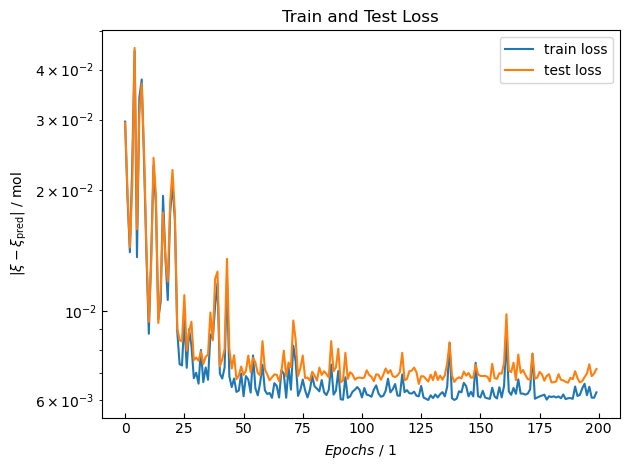

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = 0.9645532190352717
Test Dataset: R^2 = 0.9643560885881404


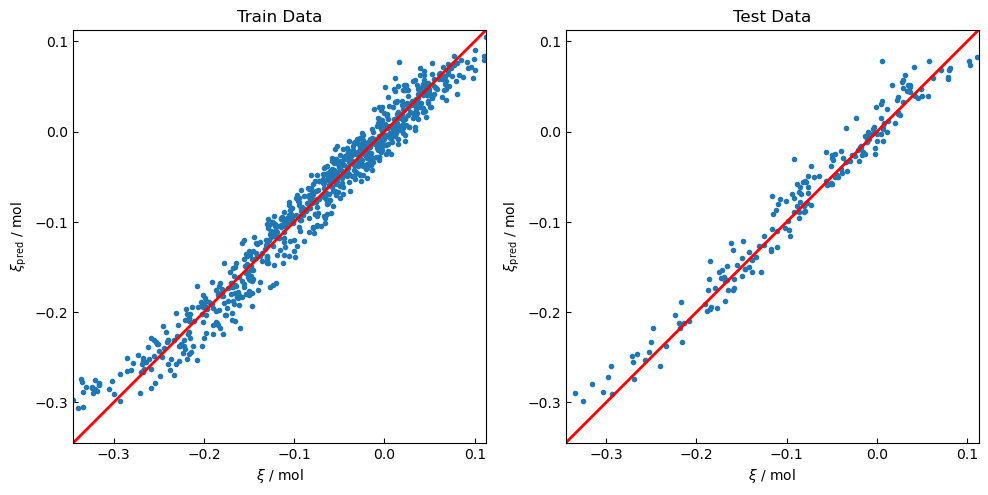

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())


print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))    

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

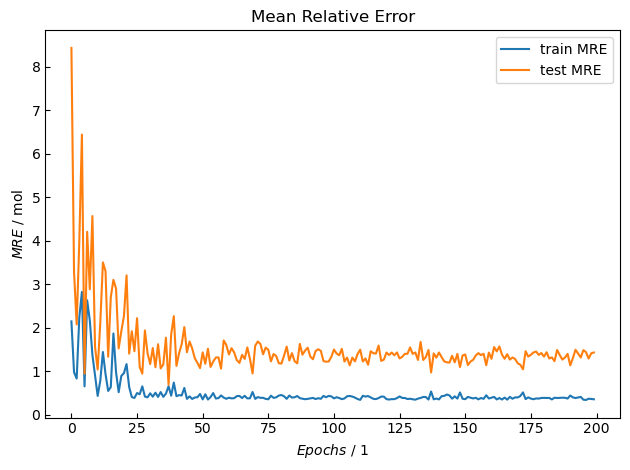

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

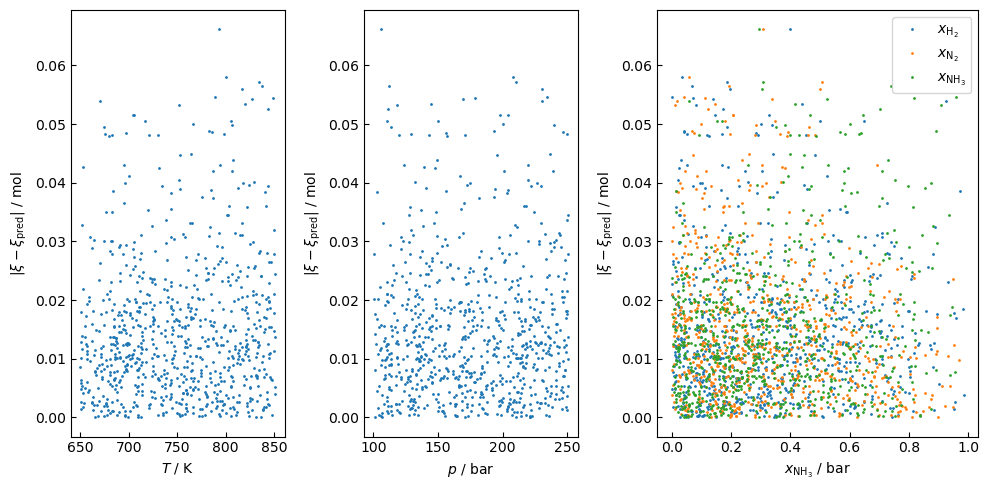

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

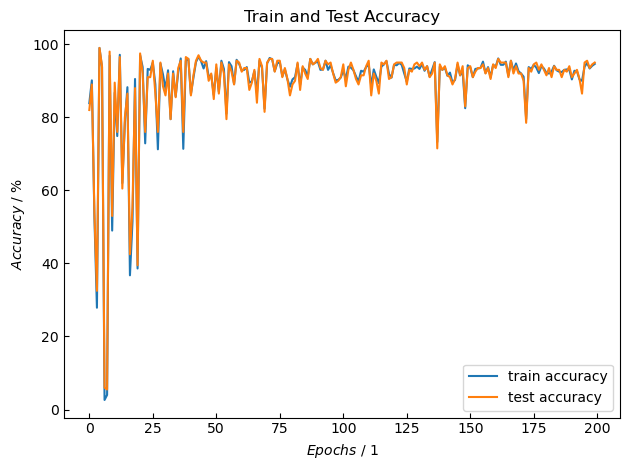

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[7.9419e+02, 1.7435e+02, 8.0503e-01, 1.8309e-01, 1.1873e-02],
        [7.0801e+02, 1.8281e+02, 4.6131e-01, 4.0288e-01, 1.3581e-01],
        [7.3734e+02, 2.4739e+02, 4.3876e-01, 4.4509e-01, 1.1615e-01],
        [7.3026e+02, 2.3366e+02, 1.0977e-01, 6.9995e-01, 1.9028e-01],
        [7.1300e+02, 2.0419e+02, 4.0541e-01, 3.0591e-01, 2.8868e-01],
        [6.9159e+02, 2.4126e+02, 3.0676e-01, 9.5072e-03, 6.8373e-01],
        [7.8739e+02, 1.5809e+02, 3.0838e-01, 6.8518e-01, 6.4418e-03],
        [6.9689e+02, 1.5650e+02, 3.8298e-01, 1.8143e-01, 4.3559e-01],
        [7.6287e+02, 2.0853e+02, 1.6747e-01, 1.8084e-01, 6.5169e-01],
        [7.6973e+02, 1.3614e+02, 6.0239e-01, 4.9534e-02, 3.4807e-01],
        [7.3292e+02, 1.7463e+02, 7.0395e-01, 2.5358e-01, 4.2472e-02],
        [7.8662e+02, 1.4209e+02, 1.3679e-01, 8.1887e-01, 4.4340e-02],
        [8.3091e+02, 1.9858e+02, 3.8903e-01, 9.7260e-02, 5.1371e-01],
        [7.8223e+02, 1.6881e+02, 2.1817e-02, 2.5589e-01, 7.2230e-01],
        [6.6261e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.8622, 0.5748, 1.0046, 0.7900, 1.0065], requires_grad=True),
 Parameter containing:
 tensor([-0.0993,  0.0228, -0.0023,  0.2604, -0.0562], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3444, -0.0913,  0.2965,  0.1832, -0.5902],
         [-0.0101, -0.2463,  0.3822, -0.3002, -0.4307],
         [ 0.4585, -0.2181, -0.0256, -0.3566,  0.0827],
         [ 0.2897,  0.2038, -0.0893,  0.3727,  0.2585],
         [ 0.2508, -0.0374,  0.0755, -0.0008, -0.2738],
         [ 0.1043, -0.0778,  0.0015, -0.2294,  0.2469],
         [ 0.1483, -0.1316,  0.0751, -0.5126,  0.3876],
         [-0.1279, -0.2225, -0.2653, -0.0921,  0.0416],
         [ 0.2116, -0.2723, -0.6115,  0.2908, -0.0631],
         [-0.0313,  0.0509, -0.3054, -0.2164, -0.1126]], requires_grad=True),
 Parameter containing:
 tensor([-0.1549,  0.2981, -0.1127, -0.1276, -0.0431, -0.0721, -0.3841, -0.0370,
         -0.1654,  0.0819], requires_grad=True),
 Parameter containing:
 tensor([[-0.1280,  0.0486

In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.8920, 0.6275, 0.5209, 0.1162, 0.7481],
        [0.3677, 0.8758, 0.8151, 0.1388, 0.0332]])
tensor([[-0.2551],
        [ 0.0825]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[6.9609e+02, 1.6460e+02, 3.8021e-01, 5.6382e-01, 5.5977e-02],
        [7.4725e+02, 2.3517e+02, 4.9660e-02, 5.5560e-01, 3.9474e-01],
        [7.8489e+02, 1.2609e+02, 6.5320e-02, 7.3103e-01, 2.0365e-01],
        [7.8087e+02, 2.3621e+02, 6.7555e-01, 3.0135e-01, 2.3097e-02],
        [7.3840e+02, 1.8261e+02, 6.4733e-01, 2.3376e-01, 1.1890e-01],
        [6.5602e+02, 1.4489e+02, 4.1158e-01, 3.4166e-01, 2.4676e-01],
        [6.8561e+02, 2.1764e+02, 4.3382e-01, 2.7399e-01, 2.9219e-01],
        [7.8275e+02, 1.4918e+02, 2.5387e-01, 1.1665e-01, 6.2948e-01],
        [6.6498e+02, 1.7229e+02, 5.7257e-01, 1.9518e-01, 2.3224e-01],
        [6.8742e+02, 2.4684e+02, 3.9258e-01, 2.4294e-01, 3.6448e-01],
        [8.3133e+02, 2.0189e+02, 3.0774e-01, 6.7303e-01, 1.9231e-02],
        [6.8419e+02, 1.2634e+02, 1.5571e-01, 5.5756e-01, 2.8673e-01],
        [6.5312e+02, 2.0496e+02, 3.0368e-01, 2.5637e-01, 4.3995e-01],
        [8.4743e+02, 2.1317e+02, 1.0432e-01, 4.9683e-01, 3.9884e-01],
        [8.3996e+02,